# Data Science project - OD Travel time Predictor
Students : Alix MEULOT, Anaëlle MARTY, Ghislain MUTABAZI, Nathan DAMBREVILLE

## <u> **I/ Data preprocessing** </u>
###  <u> **0 - Imports** </u>
#### a/ Libraries import

In [1]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn import tree

from functions.modelling import *

print("✅ Libraries successfully imported")

✅ Libraries successfully imported


#### b/ `read_whole_pandas_df` function import

In [2]:
alt_path = 'data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv'

from functions.importing import read_whole_pandas_df

print(f"✅ read_whole_pandas_df function imported; alternative_path set as:\n{alt_path}")

✅ read_whole_pandas_df function imported; alternative_path set as:
data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv


#### c/ Velo'v data import

In [3]:
# Data folder's path
BASE_PATH = r"data/"
# Velo'v data's path
LYON_PATH = BASE_PATH + r"VELO-LYON/Trajets VELOV */*.csv"
# Velo'v stations locations file's path
LYON_LOCATIONS = BASE_PATH + r"VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json"
# Lyon's contours dataset's path
LYON_IRIS = BASE_PATH + r"iris_lyon.shp"
# Coordinates of the center of Lyon
LYON_CENTER = (45.764043, 4.835659)
# Importing the data into a dataframe
df_lyon = read_whole_pandas_df(LYON_PATH, alternative_path=alt_path, sep = ";", enc = "ISO-8859-1", 
                               columns = ["id_exit_station", "exit_station", "date_exit", "id_return_station", "return_station", "date_return"], alternative_dataset=False)
print(f"✅ All datasets were successfully imported")

df_lyon["date_exit"] = pd.to_datetime(df_lyon['date_exit'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
df_lyon["date_return"] = pd.to_datetime(df_lyon['date_return'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
print(f"✅ The columns |date_exit| and |date_return| were successfully converted to datetime.")
df_lyon.head()

Reading file data/VELO-LYON\Trajets VELOV 2019\VELOV_TRAJETS_2019_T1.csv
Reading file data/VELO-LYON\Trajets VELOV 2019\VELOV_TRAJETS_2019_T2.csv
Reading file data/VELO-LYON\Trajets VELOV 2019\VELOV_TRAJETS_2019_T3.csv
Reading file data/VELO-LYON\Trajets VELOV 2019\VELOV_TRAJETS_2019_T4.csv
Reading file data/VELO-LYON\Trajets VELOV 2020\VELOV_TRAJETS_2020_T1.csv
Reading file data/VELO-LYON\Trajets VELOV 2020\VELOV_TRAJETS_2020_T2.csv
Reading file data/VELO-LYON\Trajets VELOV 2020\VELOV_TRAJETS_2020_T3.csv
Reading file data/VELO-LYON\Trajets VELOV 2020\VELOV_TRAJETS_2020_T4.csv
✅ All datasets were successfully imported
✅ The columns |date_exit| and |date_return| were successfully converted to datetime.


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00
2,6037,6037 - CITÉ INTERNATIONALE / INTERPOL,2019-01-01 00:02:00+01:00,10025.0,10025 - TOTEM,2019-01-01 00:32:00+01:00
3,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00
4,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00


#### d/ Weather data import
##### 1) CSV import
> "Données climatologiques de base - quotidiennes" Meteo-France.
> https://meteo.data.gouv.fr/datasets/6569b51ae64326786e4e8e1a

In [4]:
METEO_PATH = BASE_PATH + r"data-meteo/Q_69_previous-1950-2023_RR-T-Vent.csv"

from functions.importing import read_meteo_data

print(f"✅ read_meteo_data function imported with path:\n{METEO_PATH}")

df_meteo = read_meteo_data(METEO_PATH)
print("✅ The weather dataset was successfully imported")

display(df_meteo.head(5))
df_meteo.shape

✅ read_meteo_data function imported with path:
data/data-meteo/Q_69_previous-1950-2023_RR-T-Vent.csv
Lecture du fichier météo : data/data-meteo/Q_69_previous-1950-2023_RR-T-Vent.csv
✅ The weather dataset was successfully imported


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,HXI2,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR
0,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630301,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630302,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630303,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630304,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630305,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(1245508, 58)

In this dataset, we have acces to several informations related to the weather conditions. In our model, we will focus on the effect of the wind, the temperature and precipitation. According to the "weather code", the columns below are: 
- RR : precipitation (mm) 
- TN,TX ,TM  : minimal temperature, maximum temperature, mean temparture 
- FF : wind

###  <u> **1 - Adding intermediate columns** </u>
#### a/ Floored datetime column

In [5]:
df_lyon['datetime_1h'] = df_lyon['date_exit'].dt.floor("1H")
df_lyon.head()

C:\Users\ndamb\AppData\Local\Temp\ipykernel_25332\2808807517.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_lyon['datetime_1h'] = df_lyon['date_exit'].dt.floor("1H")


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00,2019-01-01 00:00:00+01:00
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00,2019-01-01 00:00:00+01:00
2,6037,6037 - CITÉ INTERNATIONALE / INTERPOL,2019-01-01 00:02:00+01:00,10025.0,10025 - TOTEM,2019-01-01 00:32:00+01:00,2019-01-01 00:00:00+01:00
3,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00,2019-01-01 00:00:00+01:00
4,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00,2019-01-01 00:00:00+01:00


#### b/ `day`, `month`, and `travel_time` columns
**NB:** The travel time is computed in minutes.

In [6]:
df_lyon['day'] = df_lyon.date_exit.dt.day_of_week
df_lyon['month'] = df_lyon.date_exit.dt.month
df_lyon['travel_time'] =  (df_lyon.date_return-df_lyon.date_exit).dt.total_seconds()/60
df_lyon.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,20.0
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,8.0
2,6037,6037 - CITÉ INTERNATIONALE / INTERPOL,2019-01-01 00:02:00+01:00,10025.0,10025 - TOTEM,2019-01-01 00:32:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,30.0
3,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,20.0
4,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,15.0


###  <u> **2 - Adding the `distance` column** </u>

In [7]:
gdf_stations = gpd.read_file(LYON_LOCATIONS)
gdf_stations.to_crs('2154', inplace=True)

coords = np.array([[geom.x, geom.y] for geom in gdf_stations.geometry.centroid])
dist_matrix = pairwise_distances(coords, metric="euclidean")
df_dist = pd.DataFrame(dist_matrix, index=gdf_stations['idstation'], columns=gdf_stations['idstation'])
display(df_dist.head())

df_lyon = df_lyon[df_lyon.id_exit_station.isin(df_dist.index) & df_lyon.id_return_station.isin(df_dist.index)].copy()
row_idx = df_dist.index.get_indexer(df_lyon.id_exit_station)
col_idx = df_dist.columns.get_indexer(df_lyon.id_return_station)
df_lyon["distance"] = df_dist.to_numpy()[row_idx, col_idx]
df_lyon.head()

idstation,7024,10063,10021,8038,7045,6045,8056,8015,7057,7007,...,3035,6039,30002,12005,2027,3040,7017,3138,10049,10044
idstation,,,,,,,,,,,,,,,,,,,,,
7024,0.000000,3672.322221,4038.271301,2101.306115,1728.531155,2359.789599,1897.619990,2771.548411,1581.022503,1739.714329,...,1487.311727,2209.079367,8316.839400,7914.027093,1190.596433,1448.733485,1397.488839,1707.214746,4936.861621,5241.842046
10063,3672.322221,0.000000,367.937601,1918.014222,5276.485492,2393.483029,3362.975962,2193.760999,4699.773041,5159.729411,...,2185.076724,2763.907648,6395.079493,4458.602747,4860.315824,2233.220170,4667.580451,2109.599779,1478.056510,2520.604551
10021,4038.271301,367.937601,0.000000,2269.206815,5644.183932,2665.024201,3700.574285,2477.416757,5062.122623,5525.999425,...,2550.967781,3042.980467,6250.871362,4115.750370,5225.466883,2596.741636,5032.708705,2457.739820,1175.815415,2354.611591
8038,2101.306115,1918.014222,2269.206815,0.000000,3484.503141,2327.918947,1467.055847,883.373258,2817.475111,3322.282657,...,940.820395,2518.623358,7840.242909,6376.168575,3252.453650,1066.873708,2814.886550,1368.271058,3379.142600,4169.994273
7045,1728.531155,5276.485492,5644.183932,3484.503141,0.000000,4061.439765,2522.986998,3875.840707,919.283986,340.362043,...,3133.747731,3865.225819,9954.924357,9612.529985,932.679947,3123.005262,758.389211,3425.591997,6614.809720,6970.331063


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time,distance
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,20.0,1137.895337
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,8.0,1873.815972
2,6037,6037 - CITÉ INTERNATIONALE / INTERPOL,2019-01-01 00:02:00+01:00,10025.0,10025 - TOTEM,2019-01-01 00:32:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,30.0,2777.866158
3,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,20.0,3962.183210
4,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,15.0,1352.710257


###  <u> **3 - Filtering** </u>
#### i/ Filtering the Velo'v data based on speed

In [8]:
# Creating a `speed` column based on the travel time and the distance (values in km/h for future readability)
df_lyon["speed"] = (df_lyon["distance"]/1000) / (df_lyon["travel_time"]/60)
# Filtering the data where the speed is below 10 km/h or above 30 km/h
df_lyon = df_lyon[df_lyon.speed.between(3,40)]
# Filtering the travels where the exit station and the return station are identical
df_lyon = df_lyon[df_lyon.id_exit_station != df_lyon.id_return_station]

print("There are ", df_lyon.shape[0], "travels after filtering.")
df_lyon.sample(10)

There are  14221345 travels after filtering.


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time,distance,speed
89434,3100,3100 - SISLEY / DAUPHINE,2019-01-07 13:18:00+01:00,3089.0,3089 - TRARIEUX / LACASSAGNE,2019-01-07 13:27:00+01:00,2019-01-07 13:00:00+01:00,0.0,1.0,9.0,1784.076275,11.893842
4944492,7014,7014 - MARSEILLE / FÉLISSENT,2019-08-05 08:43:00+02:00,2028.0,2028 - SAINTE-BLANDINE,2019-08-05 08:55:00+02:00,2019-08-05 08:00:00+02:00,0.0,8.0,12.0,1774.702653,8.873513
13494356,3087,3087 - PART-DIEU / GARIBALDI,2020-09-18 13:54:00+02:00,5005.0,5005 - SAINT-PAUL,2020-09-18 14:04:00+02:00,2020-09-18 13:00:00+02:00,4.0,9.0,10.0,1981.713613,11.890282
8257209,10007,10007 - PIATON / CONDORCET,2019-12-18 08:33:00+01:00,6012.0,6012 - PLACE PUVIS DE CHAVANNES,2019-12-18 08:45:00+01:00,2019-12-18 08:00:00+01:00,2.0,12.0,12.0,1800.467906,9.002340
13124801,2006,2006 - PLACE DE L'HIPPODROME,2020-09-09 08:09:00+02:00,9002.0,9002 - MAIRIE DU 9E,2020-09-09 08:29:00+02:00,2020-09-09 08:00:00+02:00,2.0,9.0,20.0,3472.449077,10.417347
11263384,3099,3099 - PLACE SAINTE ANNE,2020-06-26 07:54:00+02:00,10055.0,10055 - CONDORCET / GALLINE,2020-06-26 08:06:00+02:00,2020-06-26 07:00:00+02:00,4.0,6.0,12.0,2152.957635,10.764788
7260338,4007,4007 - PLACE FLAMMARION,2019-11-04 17:55:00+01:00,4005.0,4005 - PLACE BERTONE,2019-11-04 18:09:00+01:00,2019-11-04 17:00:00+01:00,0.0,11.0,14.0,1119.435139,4.797579
13098136,9041,9041 - CARRET / SÉDALLIAN,2020-09-08 15:04:00+02:00,9013.0,9013 - QUAI PAUL SÉDALLIAN,2020-09-08 15:08:00+02:00,2020-09-08 15:00:00+02:00,1.0,9.0,4.0,730.189396,10.952841
5823446,2017,2017 - RÉPUBLIQUE / FERRANDIÈRE,2019-09-13 23:55:00+02:00,7034.0,7034 - PISCINE DU RHÔNE,2019-09-14 00:02:00+02:00,2019-09-13 23:00:00+02:00,4.0,9.0,7.0,966.914721,8.287840
6079628,7056,7056 - PLACE RASPAIL,2019-09-21 19:27:00+02:00,7035.0,7035 - MARSEILLE / UNIVERSITÉ,2019-09-21 19:31:00+02:00,2019-09-21 19:00:00+02:00,5.0,9.0,4.0,546.580599,8.198709


Average speed of the filtered data:  9.76 km/h
Average time for a 15km travel:  92 minutes


c:\Users\ndamb\anaconda3\envs\DataSciencesFurno\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


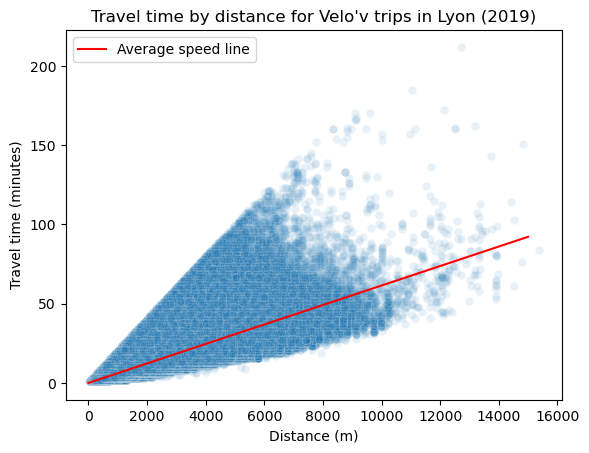

In [9]:
# Displaying a scatter graph of the travel time by the distance
sns.scatterplot(data=df_lyon, x="distance", y="travel_time", alpha=0.1)
plt.title("Travel time by distance for Velo'v trips in Lyon (2019)")
plt.xlabel("Distance (m)")
plt.ylabel("Travel time (minutes)")
# Adding the average speed line computed from the filtered data
avg_speed = df_lyon["speed"].sum() / (df_lyon["speed"].count())  # in km/h
print("Average speed of the filtered data: ", round(avg_speed,2), "km/h")
print("Average time for a 15km travel: ", round(60*15/avg_speed), "minutes")
plt.plot([0, 15000], [0, 60*15/(avg_speed)], color='red', label='Average speed line')
plt.legend()
plt.show()

#### ii/ Time filtering the weather data
We will merge the weather dataset with the  velo-lyon dataset. We have to work on the same period, so we clean our weather dataset. The period selected is between the 01/01/2019 and the 22/04/2021

In [10]:
# Date conversion
df_meteo['date'] = pd.to_datetime(df_meteo['AAAAMMJJ'].astype(str), format='%Y%m%d')

# Filter data between 2019-01-01 and 2021-04-22
start_date = pd.to_datetime("2019-01-01")
end_date = pd.to_datetime("2021-04-22")

df_meteo = df_meteo[(df_meteo['date'] >= start_date) & (df_meteo['date'] <= end_date)]
df_meteo.head()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR,date
23102,69007001,AMPUIS,45.490667,4.811167,157,20190101,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01
23103,69007001,AMPUIS,45.490667,4.811167,157,20190102,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-02
23104,69007001,AMPUIS,45.490667,4.811167,157,20190103,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-03
23105,69007001,AMPUIS,45.490667,4.811167,157,20190104,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-04
23106,69007001,AMPUIS,45.490667,4.811167,157,20190105,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-05


In [11]:
#Convert AAAAMMJJ to datetime
df_meteo["AAAAMMJJ"] = df_meteo["AAAAMMJJ"].astype(int).astype(str)
df_meteo["datetime_day"] = pd.to_datetime(df_meteo["AAAAMMJJ"], format="%Y%m%d").dt.date

# Verify the conversion
print(df_meteo[["AAAAMMJJ", "datetime_day"]].head())

       AAAAMMJJ datetime_day
23102  20190101   2019-01-01
23103  20190102   2019-01-02
23104  20190103   2019-01-03
23105  20190104   2019-01-04
23106  20190105   2019-01-05


#### iii/ Filtering the weather data to 1 station

In [12]:
df_meteo.columns

Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'QRR',
       'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM',
       'TNTXM', 'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50',
       'QTN50', 'DG', 'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY',
       'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI',
       'QHXI', 'FXI2', 'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S',
       'QFXI3S', 'DXI3S', 'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR', 'date',
       'datetime_day'],
      dtype='object')

In [13]:
df_meteo['NOM_USUEL'].unique()


array(['AMPUIS', 'ANCY_SAPC', 'LE BREUIL', 'BRINDAS', 'LYON-BRON',
       'CALUIRE4', 'CERCIE EN BEAUJOLAIS', 'CONDRIEU',
       'COURS LA VILLE_SAPC', 'LES HAIES', 'JULLIE', 'LAMURE-SUR-AZER',
       'LANCIE', 'LIERGUES_SAPC', "LYON TETE D'OR", 'LYON-FOURVIERE',
       'MONSOLS', 'MONTROTTIER', 'MORNANT', 'POMMIERS', 'PONT TRAMBOUZE',
       'AZOLETTE', 'LES SAUVAGES', 'ST-CYR-CHATOUX', 'ST-DIDIER-RIVER',
       'ST-DIDIER-BEAUJ', "ST-GENIS-L'ARGENTIERE", 'ST-GENIS-LAVAL',
       'ST-GEORGES-REN', 'ST-GERMAIN-L AR', 'POPEY', 'ST-SYMPHORIEN-C',
       'SAINT-VERAND', 'TRADES', 'VAUX-EN-BEAUJOL', 'VAUXRENARD',
       'VILLEFRANCHE', 'CORBAS', 'RILLIEUX', 'LYON-ST EXUPERY'],
      dtype=object)

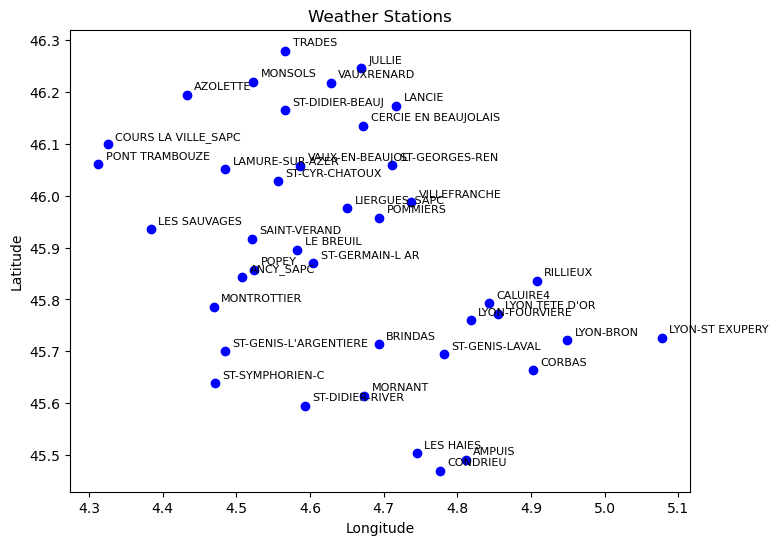

In [14]:
# Supprimer les doublons pour ne garder qu'une ligne par station
stations = df_meteo[['NOM_USUEL','LAT','LON']].drop_duplicates()

plt.figure(figsize=(8,6))
plt.scatter(stations['LON'], stations['LAT'], color='blue')

# Ajouter les noms des stations
for i, row in stations.iterrows():
    plt.text(row['LON'] + 0.01, row['LAT'] + 0.01, row['NOM_USUEL'], fontsize=8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weather Stations")
plt.show()



In [15]:
# Exemple : coordonnées du centre de Lyon
lyon_center = (45.75, 4.85)

# Supprimer doublons pour garder une ligne par station
stations = df_meteo[['NOM_USUEL','LAT','LON']].drop_duplicates()

# Fonction Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # rayon Terre en km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

# Calculer la distance de chaque station au centre de Lyon
stations['distance_lyon_km'] = stations.apply(
    lambda row: haversine(row['LAT'], row['LON'], lyon_center[0], lyon_center[1]),
    axis=1
)

# Trier par distance
stations = stations.sort_values('distance_lyon_km')

# Afficher les 5 stations les plus proches
print(stations[['NOM_USUEL','LAT','LON','distance_lyon_km']].head())


             NOM_USUEL        LAT       LON  distance_lyon_km
470489  LYON TETE D'OR  45.772833  4.855167          2.570359
507643  LYON-FOURVIERE  45.759667  4.818167          2.693517
179616        CALUIRE4  45.792833  4.843500          4.789420
817072  ST-GENIS-LAVAL  45.694667  4.782333          8.090095
109675       LYON-BRON  45.721333  4.949167          8.330414


In [16]:
# Liste des colonnes vent
vent_cols = ['FFM','FF2M','FXI','FXI2','FXI3S',"RR"]

# Vérifier par station
vent_dispo = df_meteo.groupby('NOM_USUEL')[vent_cols].apply(lambda x: x.notna().sum())

# Afficher les stations et le nombre de valeurs disponibles
print(vent_dispo.sort_values(by='FFM', ascending=False))


                       FFM  FF2M  FXI  FXI2  FXI3S   RR
NOM_USUEL                                              
ST-GEORGES-REN         843     0  843     0    516  843
LYON-ST EXUPERY        843     0  842     0    724  843
LYON-BRON              842     0  841     0    836  843
VAUXRENARD             838     0  838     0    486  843
LES SAUVAGES           818     0  821     0    490  843
BRINDAS                817     0  818     0    492  843
ANCY_SAPC                0     0    0     0      0  843
AMPUIS                   0     0    0     0      0  700
CORBAS                   0     0    0     0      0  365
CONDRIEU                 0     0    0     0      0  731
CERCIE EN BEAUJOLAIS     0     0    0     0      0  731
CALUIRE4                 0     0    0     0      0  700
AZOLETTE                 0     0    0     0      0  304
LE BREUIL                0     0    0     0      0  843
LANCIE                   0     0    0     0      0  700
COURS LA VILLE_SAPC      0     0    0     0     

We keep the meteo information of the station Lyon - Bron because it is the closest station from the center of Lyon that measures, the temperature the wind and the precipitation. 

In [17]:
# Filter on the station "LYON-BRON"
meteo_bron = df_meteo[df_meteo['NOM_USUEL'] == "LYON-BRON"].copy()

# Verify the result 
print(meteo_bron[['NOM_USUEL', 'LAT', 'LON']].drop_duplicates())
print(meteo_bron.head())


        NOM_USUEL        LAT       LON
109675  LYON-BRON  45.721333  4.949167
        NUM_POSTE  NOM_USUEL        LAT       LON  ALTI  AAAAMMJJ   RR  QRR  \
109675   69029001  LYON-BRON  45.721333  4.949167   202  20190101  0.0  1.0   
109676   69029001  LYON-BRON  45.721333  4.949167   202  20190102  0.0  1.0   
109677   69029001  LYON-BRON  45.721333  4.949167   202  20190103  0.0  1.0   
109678   69029001  LYON-BRON  45.721333  4.949167   202  20190104  0.0  1.0   
109679   69029001  LYON-BRON  45.721333  4.949167   202  20190105  0.0  1.0   

         TN  QTN  ...  FXI3S  QFXI3S  DXI3S  QDXI3S   HXI3S  QHXI3S  DRR  \
109675  6.5  1.0  ...    8.6     1.0    NaN     NaN  1738.0     9.0  0.0   
109676  4.0  1.0  ...   14.3     1.0    NaN     NaN  1410.0     9.0  0.0   
109677 -0.1  1.0  ...   12.6     1.0    NaN     NaN  1425.0     9.0  0.0   
109678 -0.2  1.0  ...   10.6     1.0    NaN     NaN  1319.0     9.0  0.0   
109679  1.2  1.0  ...   10.9     1.0    NaN     NaN   117.0     9.0

###  <u> **4 - Converting the weather data into usable data for modelling** </u>


In [18]:
# Créer la température moyenne si TM non fiable
meteo_bron['T_moy'] = meteo_bron[['TN','TX']].mean(axis=1)

# Convertir le vent (rafale max 3s FXI3S) en km/h
meteo_bron['vent_kmh'] = meteo_bron['FFM'] * 3.6

# Créer un DataFrame journalier moyen
meteo_jour = meteo_bron.groupby('AAAAMMJJ').agg({
    'T_moy': 'mean',        # Température moyenne
    'RR': 'sum',            # Total précipitations par jour
    'vent_kmh': 'mean'      # Vent moyen par jour
}).reset_index()

# Afficher les premières lignes
display(meteo_jour.head())
meteo_jour.shape


,AAAAMMJJ,T_moy,RR,vent_kmh
0,20190101,6.90,0.0,13.32
1,20190102,5.45,0.0,21.96
2,20190103,2.45,0.0,20.52
3,20190104,2.75,0.0,18.00
4,20190105,2.75,0.0,19.08


(843, 4)

In [19]:
#We create the temperature categories

conditions_temp = [
    (meteo_jour["T_moy"] < 0), 
    (meteo_jour["T_moy"] >= 0) & (meteo_jour["T_moy"] < 10),
    (meteo_jour["T_moy"] >= 10) & (meteo_jour["T_moy"] < 20),
    (meteo_jour["T_moy"] >= 20)
]
categories_temp = ["cold", "cool", "warm", "very_warm"]
meteo_jour["temp_category"] = np.select(conditions_temp, categories_temp, default="unknown")

#We create the rainfall categories

conditions_RR = [
    (meteo_jour["RR"] == 0),
    (meteo_jour["RR"] > 0) & (meteo_jour["RR"] <= 2),
    (meteo_jour["RR"] > 2) & (meteo_jour["RR"] <= 10),
    (meteo_jour["RR"] > 10)
]

categories_RR = ["none", "light", "moderate", "heavy"]

meteo_jour["rain_category"] = np.select(conditions_RR, categories_RR, default="none")

#We create the wind categories  

conditions_wind = [
    (meteo_jour["vent_kmh"] < 10),
    (meteo_jour["vent_kmh"] >= 10) & (meteo_jour["vent_kmh"] < 20),
    (meteo_jour["vent_kmh"] >= 20) & (meteo_jour["vent_kmh"] < 40),
    (meteo_jour["vent_kmh"] >= 40)
]   
categories_wind = ["calm", "light", "windy", "stormy"]
meteo_jour["wind_category"] = np.select(conditions_wind, categories_wind, default="unknown")

meteo_jour

,AAAAMMJJ,T_moy,RR,vent_kmh,temp_category,rain_category,wind_category
0,20190101,6.90,0.0,13.32,cool,none,light
1,20190102,5.45,0.0,21.96,cool,none,windy
2,20190103,2.45,0.0,20.52,cool,none,windy
3,20190104,2.75,0.0,18.00,cool,none,light
4,20190105,2.75,0.0,19.08,cool,none,light
...,...,...,...,...,...,...,...
838,20210418,9.25,0.0,15.48,cool,none,light
839,20210419,10.25,0.0,10.44,warm,none,light
840,20210420,11.15,0.2,7.20,warm,light,calm
841,20210421,12.80,0.2,7.92,warm,light,calm


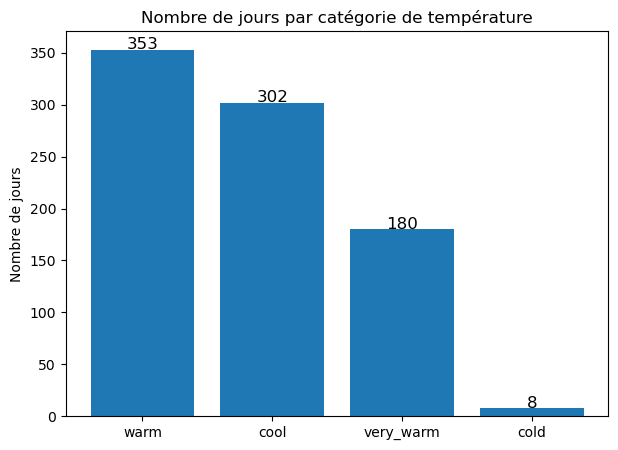

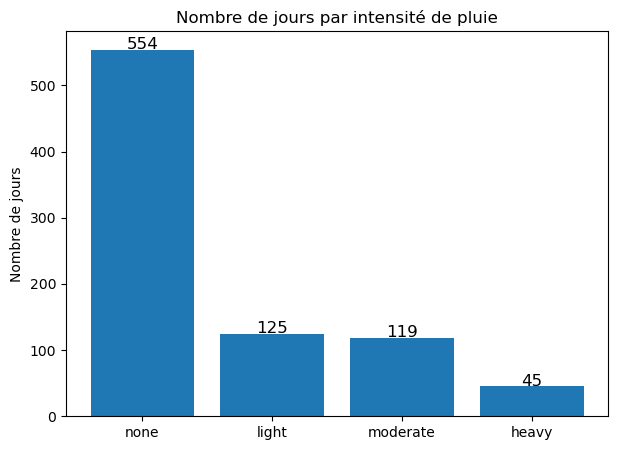

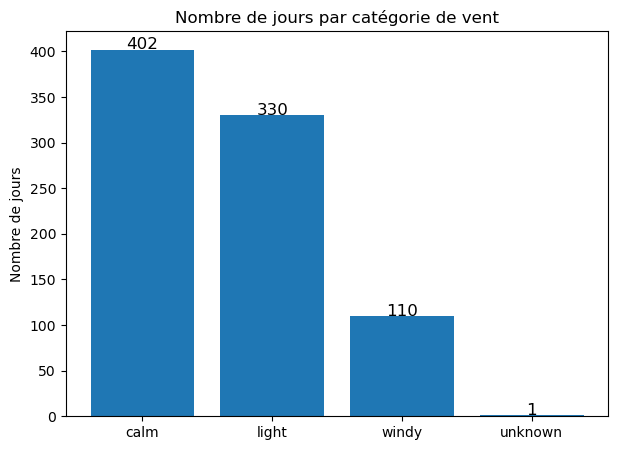

In [20]:
# Plot for temperature categories
plt.figure(figsize=(7,5))
temp_counts = meteo_jour["temp_category"].value_counts()

plt.bar(temp_counts.index, temp_counts.values)
plt.ylabel("Nombre de jours")
plt.title("Nombre de jours par catégorie de température")

for i, v in enumerate(temp_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()

# Plot for rain categories
plt.figure(figsize=(7,5))
rain_counts = meteo_jour["rain_category"].value_counts()

plt.bar(rain_counts.index, rain_counts.values)
plt.ylabel("Nombre de jours")
plt.title("Nombre de jours par intensité de pluie")

for i, v in enumerate(rain_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()

# Plot for wind categories
plt.figure(figsize=(7,5))
wind_counts = meteo_jour["wind_category"].value_counts()

plt.bar(wind_counts.index, wind_counts.values)
plt.ylabel("Nombre de jours")
plt.title("Nombre de jours par catégorie de vent")

for i, v in enumerate(wind_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()




Note : I don't know why there is an unkwon category 

In [21]:
# Convertir en string
meteo_jour["AAAAMMJJ"] = meteo_jour["AAAAMMJJ"].astype(int).astype(str)

# Transformer en datetime
meteo_jour["datetime_day"] = pd.to_datetime(meteo_jour["AAAAMMJJ"], format="%Y%m%d").dt.date

# Vérifier
print(meteo_jour)


     AAAAMMJJ  T_moy   RR  vent_kmh temp_category rain_category wind_category  \
0    20190101   6.90  0.0     13.32          cool          none         light   
1    20190102   5.45  0.0     21.96          cool          none         windy   
2    20190103   2.45  0.0     20.52          cool          none         windy   
3    20190104   2.75  0.0     18.00          cool          none         light   
4    20190105   2.75  0.0     19.08          cool          none         light   
..        ...    ...  ...       ...           ...           ...           ...   
838  20210418   9.25  0.0     15.48          cool          none         light   
839  20210419  10.25  0.0     10.44          warm          none         light   
840  20210420  11.15  0.2      7.20          warm         light          calm   
841  20210421  12.80  0.2      7.92          warm         light          calm   
842  20210422  13.85  0.0      9.00          warm          none          calm   

    datetime_day  
0     20

In [22]:
df_lyon["datetime_day"] = pd.to_datetime(df_lyon["datetime_1h"], format="%Y%m%d").dt.date
df_lyon.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time,distance,speed,datetime_day
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,20.0,1137.895337,3.413686,2019-01-01
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,8.0,1873.815972,14.053620,2019-01-01
2,6037,6037 - CITÉ INTERNATIONALE / INTERPOL,2019-01-01 00:02:00+01:00,10025.0,10025 - TOTEM,2019-01-01 00:32:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,30.0,2777.866158,5.555732,2019-01-01
3,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,20.0,3962.183210,11.886550,2019-01-01
4,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,15.0,1352.710257,5.410841,2019-01-01


In [23]:
df_meteo = df_lyon.merge(meteo_jour, on="datetime_day", how="left")
df_meteo

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time,distance,speed,datetime_day,AAAAMMJJ,T_moy,RR,vent_kmh,temp_category,rain_category,wind_category
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,20.0,1137.895337,3.413686,2019-01-01,20190101,6.90,0.0,13.32,cool,none,light
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,8.0,1873.815972,14.053620,2019-01-01,20190101,6.90,0.0,13.32,cool,none,light
2,6037,6037 - CITÉ INTERNATIONALE / INTERPOL,2019-01-01 00:02:00+01:00,10025.0,10025 - TOTEM,2019-01-01 00:32:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,30.0,2777.866158,5.555732,2019-01-01,20190101,6.90,0.0,13.32,cool,none,light
3,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,20.0,3962.183210,11.886550,2019-01-01,20190101,6.90,0.0,13.32,cool,none,light
4,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00,2019-01-01 00:00:00+01:00,1.0,1.0,15.0,1352.710257,5.410841,2019-01-01,20190101,6.90,0.0,13.32,cool,none,light
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14221340,3009,3009 - MUSEE AFRICAIN,2020-12-31 23:41:00+01:00,7036.0,7036 - GRYPHE / MONTESQUIEU,2020-12-31 23:45:00+01:00,2020-12-31 23:00:00+01:00,3.0,12.0,4.0,1114.496145,16.717442,2020-12-31,20201231,2.85,8.2,23.04,cool,moderate,windy
14221341,2035,2035 - CHILDEBERT / RIVIÈRE,2020-12-31 23:42:00+01:00,1003.0,1003 - PLACE SATHONAY,2020-12-31 23:52:00+01:00,2020-12-31 23:00:00+01:00,3.0,12.0,10.0,1132.489628,6.794938,2020-12-31,20201231,2.85,8.2,23.04,cool,moderate,windy
14221342,8035,8035 - SANS SOUCI,2020-12-31 23:43:00+01:00,1031.0,1031 - PLACE DE LA PAIX,2021-01-01 00:02:00+01:00,2020-12-31 23:00:00+01:00,3.0,12.0,19.0,3491.715445,11.026470,2020-12-31,20201231,2.85,8.2,23.04,cool,moderate,windy
14221343,3103,3103 - PLACE DANTON,2020-12-31 23:48:00+01:00,10021.0,10021 - GRANDCLÉMENT,2020-12-31 23:58:00+01:00,2020-12-31 23:00:00+01:00,3.0,12.0,10.0,2574.757449,15.448545,2020-12-31,20201231,2.85,8.2,23.04,cool,moderate,windy


## <u> **II/ Regression modelling** </u>
###  <u> **1 - Simple linear regression** </u>
#### a/ Model 0 definition

In [24]:
# STEP 1 - EXTRACTING THE RELEVANT COLUMNS
y = df_lyon['travel_time']
X = df_lyon[['distance']]

# STEP 2 - SPLITTING THE DATA INTO TRAINING AND TEST SETS
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# STEP 3 - CREATING AND TRAINING THE MODEL
model = LinearRegression() 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test) 

# Displaying the intercept with minutes (rounded to the lower value) and seconds and the average speed of the biker in km/h
print("The model's intercept is: ", int(model.intercept_), "minutes and", int((model.intercept_%1)*60), "seconds")
print("The estimated biker goes at: ", int(360/(model.coef_[0]*60))/100, "km/h in average")

# STEP 4 - EVALUATING THE MODEL
s_validation = pd.Series({
    'R²': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
})
s_validation

The model's intercept is:  1 minutes and 28 seconds
The estimated biker goes at:  10.48 km/h in average


R²      0.671317
MSE    18.182459
MAE     2.809116
dtype: float64

#### b/ Model 0 estimation

In [25]:
estimated_time_15km = model.intercept_ + 15000*model.coef_[0]
print("Estimated time for a 5km travel on bike: ", round(estimated_time_15km), "minutes")

Estimated time for a 5km travel on bike:  87 minutes


In [26]:
# Plotting a scatter graph of the travels' distance and duration (i.e. travel time) and the line of our regression model
## /!\ Code below runs in 5min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_lyon, alpha=0.1, label='Data points')
#sns.lineplot(x=X_test['distance'], y=y_pred, color='red', label='Regression line')
#plt.title('Travel Time vs Distance (with Regression Line)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

###  <u> **1 - Multiple linear regression** </u>
#### a/ Model 1 - Adding the day of the week parameter

In [27]:
# Extracting a subset of our original dataframe with only the columns at use
df_model1 = df_lyon[['distance', 'travel_time', 'datetime_1h', 'day']].copy()
# Converting day to integer type
df_model1['day'] = df_model1['day'].astype(int)
df_model1.sample(5)

,distance,travel_time,datetime_1h,day
1616913,956.998584,5.0,2019-03-16 08:00:00+01:00,5
8829532,1423.856287,8.0,2020-01-20 07:00:00+01:00,0
8975426,1854.499153,12.0,2020-01-26 14:00:00+01:00,6
5799470,3120.433174,15.0,2019-09-13 12:00:00+02:00,4
6559465,2580.926440,15.0,2019-10-07 18:00:00+02:00,0


In [28]:
# Creating a dataframe with the columns distance, travel_time, and dummies representing the day of the week
df_model1_dummies_day = pd.get_dummies(df_model1, columns=['day'], drop_first=True, dtype="int")
df_model1_dummies_day.sample(5)

,distance,travel_time,datetime_1h,day_1,day_2,day_3,day_4,day_5,day_6
5875439,810.686110,4.0,2019-09-16 05:00:00+02:00,0,0,0,0,0,0
8126103,627.974223,4.0,2019-12-12 09:00:00+01:00,0,0,1,0,0,0
11165839,436.135981,3.0,2020-06-22 22:00:00+02:00,0,0,0,0,0,0
4368747,2000.019764,13.0,2019-07-08 18:00:00+02:00,0,0,0,0,0,0
491062,1033.571285,7.0,2019-01-26 11:00:00+01:00,0,0,0,0,1,0


,Coefficient
day_6,1.256732
day_5,1.234222
day_4,0.236118
day_3,0.122078
day_2,0.077724
day_1,0.042218
distance,0.005704
intercept,1.156980


R²      0.674330
MSE    18.015792
MAE     2.799452
dtype: float64

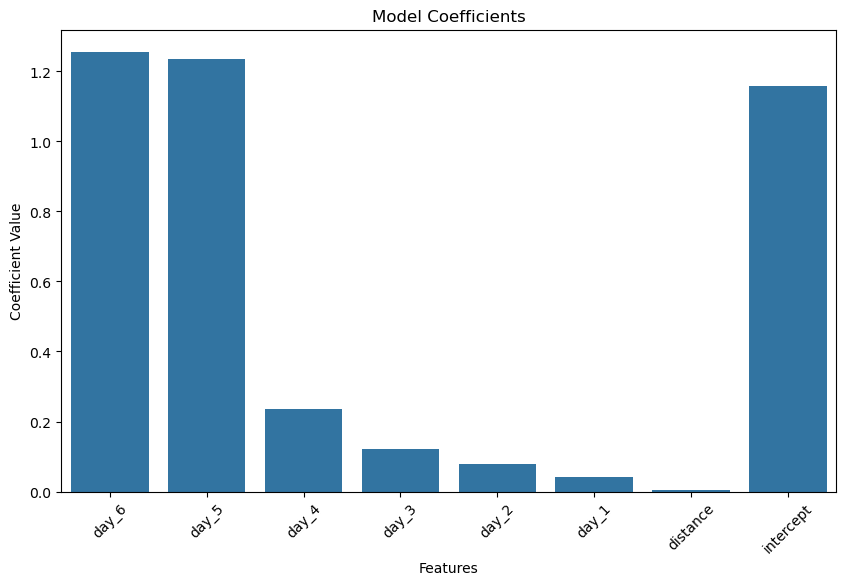

In [29]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model1_dummies_day['travel_time']
X = df_model1_dummies_day.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 1: model1_day
model1_day = LinearRegression()
model1_day.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day, X)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1 = model1_day.predict(X_test)
s_model1_validation = build_validation_serie(y_test, y_pred_model1)
display(s_model1_validation)

## Plotting a bar plot of the model's coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index())
plt.title('Model Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

## Plotting a scatter graph of the travels' distance and duration (i.e. travel time)
## and the lines of our multi-linear regression model, with different colors for each day of the week
## /!\ Code below runs in 15min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_model1_dummies, alpha=0.01, label='Data points')
#for day in range(1, 7):
#    day_columns = [col for col in X_test.columns if col.startswith('day_')]
#    day_dummies = np.zeros((len(X_test), len(day_columns)))
#    if day - 1 < len(day_columns):
#        day_dummies[:, day - 1] = 1
#    X_temp = X_test.copy()
#    X_temp[day_columns] = day_dummies
#    y_pred_day = model1_day.predict(X_temp)
#    sns.lineplot(x=X_test['distance'], y=y_pred_day, label=f'Day {day}')
#plt.title('Travel Time vs Distance (with Regression Lines for Each Day)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

#### b/ Model 1 - Adding the time of day parameter

In [30]:
# Adding the dummies column indicating which hour of the day it is
df_model1['hour'] = df_model1['datetime_1h'].dt.hour
df_model1_dummies = pd.get_dummies(df_model1, columns=['day', 'hour'], drop_first=True, dtype="int")
df_model1_dummies.sample(5)

,distance,travel_time,datetime_1h,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
12485024,1730.747125,9.0,2020-08-16 21:00:00+02:00,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4231015,2314.826443,12.0,2019-07-02 15:00:00+02:00,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5602961,2720.455603,13.0,2019-09-06 18:00:00+02:00,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8569390,1573.512589,8.0,2020-01-08 17:00:00+01:00,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9941942,2350.756417,27.0,2020-03-09 16:00:00+01:00,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


,Coefficient
day_5,1.053482
day_6,1.042989
hour_15,0.457566
hour_1,0.441966
hour_2,0.411132
hour_16,0.375548
hour_3,0.344796
day_4,0.212192
hour_14,0.205280
day_3,0.120190


R²      0.679516
MSE    17.728864
MAE     2.781946
dtype: float64

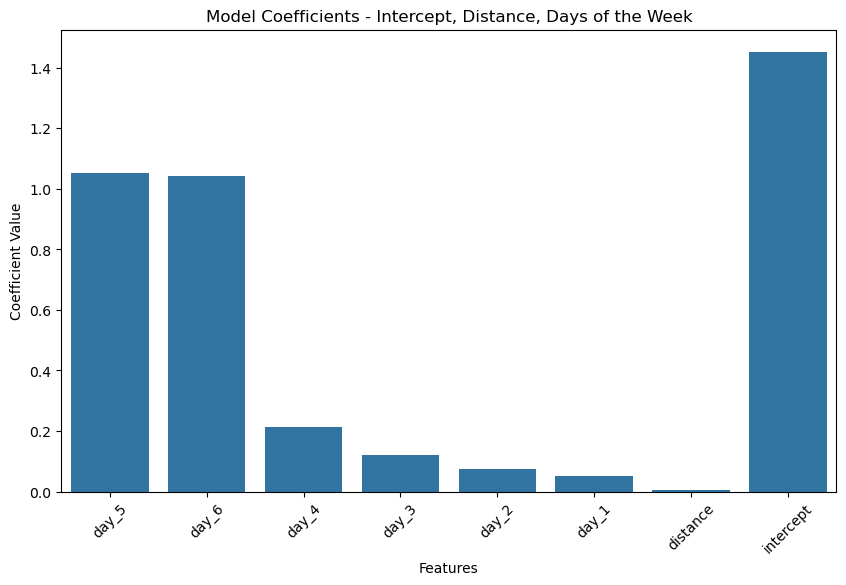

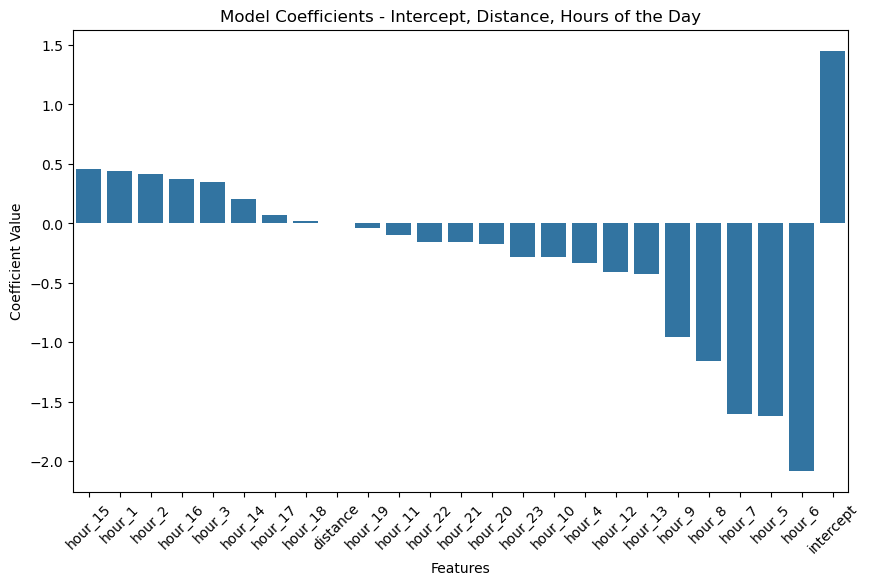

C:\Users\ndamb\AppData\Local\Temp\ipykernel_25332\1607004228.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)


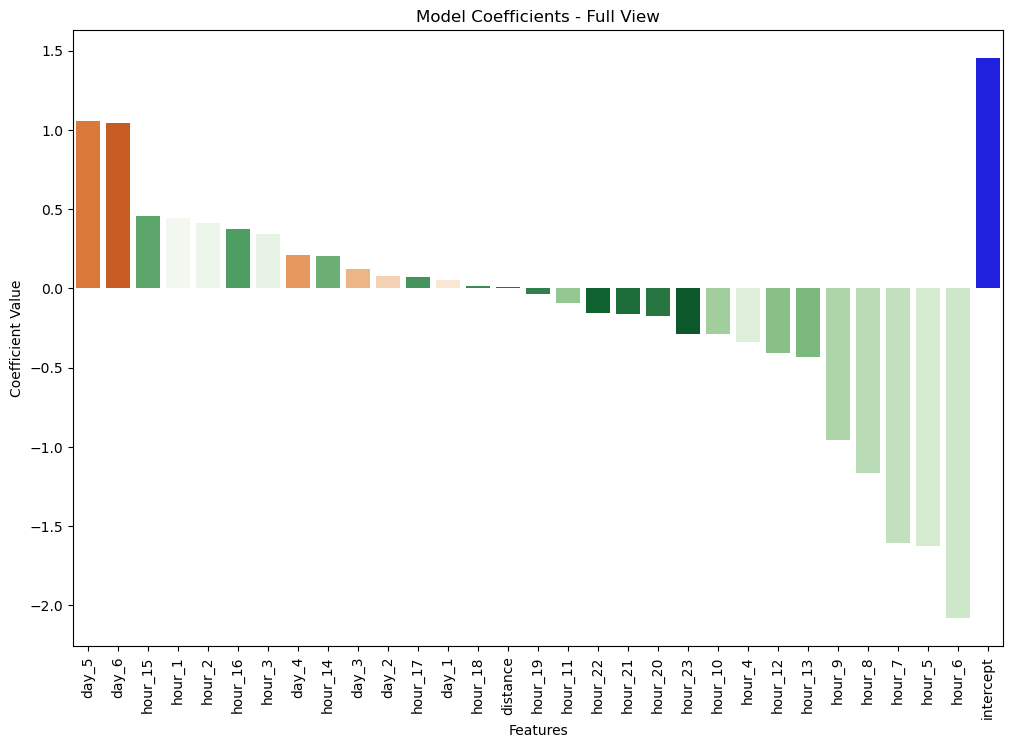

In [31]:
# Creating our multi-linear regression model, predicting the travel time based on the previous parameters and the hour of the day
## Splitting our data using my_train_test_split function
y = df_model1_dummies['travel_time']
X = df_model1_dummies.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our new model 1: model1_day_hour
model1_day_hour = LinearRegression()
model1_day_hour.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day_hour, X)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1_day_hour = model1_day_hour.predict(X_test)
s_model1_day_hour_validation = build_validation_serie(y_test, y_pred_model1_day_hour)
display(s_model1_day_hour_validation)

## Plotting 3 bar plots of the model's coefficients
### Plotting the first bar plot with the intercept, the distance and the days of the week
df_days = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('day_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_days.index, y='Coefficient', data=df_days.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Days of the Week')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the second bar plot with the intercept, the distance and the hours of the day
df_hours = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('hour_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_hours.index, y='Coefficient', data=df_hours.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Hours of the Day')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the last bar plot with all the coefficients and setting 2 different colors
### for the intercept and the distance, and setting 2 different gradient for the hours of the day
### and the days of the week
plt.figure(figsize=(12, 8))
colors = []
for idx in df_model1_coeffs.index:
    if idx == 'intercept':
        colors.append('blue')
    elif idx == 'distance':
        colors.append('red')
    elif idx.startswith('day_'):
        colors.append(plt.cm.Oranges(int(idx.split('_')[1]) * 30))
    elif idx.startswith('hour_'):
        colors.append(plt.cm.Greens(int(idx.split('_')[1]) * 10))
    else:
        colors.append('gray')
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)
plt.title('Model Coefficients - Full View')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

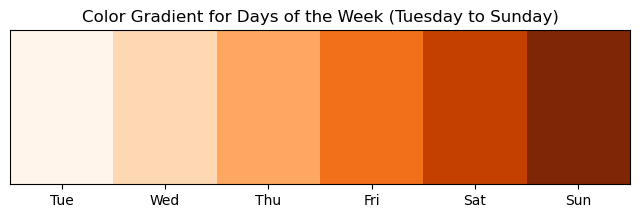

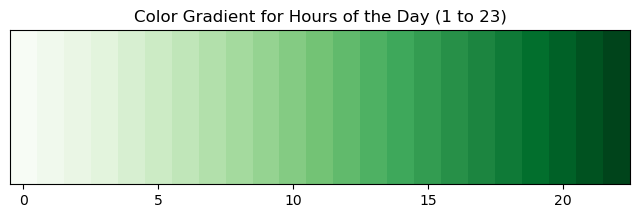

In [32]:
# Plotting a legend for the previous code that plotted the complete bar graph
## Plotting a gradient to show the colors grading from Tuesday to Sunday (1 to 6)
plt.figure(figsize=(8, 2))
gradient_days = np.linspace(0, 1, 6).reshape(1, -1)
plt.imshow(gradient_days, aspect='auto', cmap='Oranges')
plt.title('Color Gradient for Days of the Week (Tuesday to Sunday)')
# Changing the legend to show the days of the week
plt.xticks(ticks=np.arange(6), labels=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.show()

## Plotting a gradient to show the colors grading from Hour 1 to Hour 23
plt.figure(figsize=(8, 2))
gradient_hours = np.linspace(0, 1, 23).reshape(1, -1)
plt.imshow(gradient_hours, aspect='auto', cmap='Greens')
plt.title('Color Gradient for Hours of the Day (1 to 23)')
plt.yticks([])
plt.show()

In [33]:
# Estimating 15km travel times with different hours of the day and days of the week with model1_day_hour
TT_15km_model1_day_hour = {}
for day in range(7):
    for hour in range(24):
        # Creating a dataframe with the distance, day and hour
        data = {'distance': [15000]}
        for d in range(1, 7):
            data[f'day_{d}'] = [1 if d == day else 0]
        for h in range(1, 24):
            data[f'hour_{h}'] = [1 if h == hour else 0]
        X_temp = pd.DataFrame(data)
        # Predicting the travel time
        TT_15km_model1_day_hour[(day, hour)] = model1_day_hour.predict(X_temp)[0]

# Displaying the estimated travel times for a 15km trip in a dataframe
df_TT_15km_model1_day_hour = pd.DataFrame.from_dict(TT_15km_model1_day_hour, orient='index', columns=['Estimated Travel Time (minutes)'])
df_TT_15km_model1_day_hour.index = pd.MultiIndex.from_tuples(df_TT_15km_model1_day_hour.index, names=['Day of the Week', 'Hour of the Day'])
df_TT_15km_model1_day_hour = df_TT_15km_model1_day_hour.sort_index()
df_TT_15km_model1_day_hour.sample(10)

Estimated Travel Time (minutes)
Day of the Week Hour of the Day                                 
4               12                                     86.868911
                15                                     87.732503
                18                                     87.290244
3               18                                     87.198242
5               3                                      88.461022
1               9                                      86.155234
6               21                                     87.944042
0               12                                     86.656719
                10                                     86.775145
1               0                                      87.112456

In [34]:
from functions.estimator import MLR_model_estimator

# Example
test_distance = 15000  # in meters
test_travel_time = None  # unknown, to be predicted
test_datetime_1h = '2020-01-07 08:15:00'  # example datetime
test_day = 1  # Tuesday
test_month = 1  # January

sample_list = [test_distance, test_travel_time, test_datetime_1h, test_day, test_month]
pred = MLR_model_estimator(
    model=model1_day_hour,
    features=sample_list,
    feature_names=['distance','travel_time','datetime_1h','day','month'],
    model_feature_names=X.columns,   # X is the training DataFrame's columns used to fit the model
    show_steps=True
)
print(f"The predicted travel time for a {test_distance/1000} km trip is: {round(pred)} minutes")

[STEP] Starting estimation
[STEP] Extracted base features: {'distance': 15000, 'day': 1, 'datetime_1h': '2020-01-07 08:15:00', 'month': 1}
[STEP] distance = 15000.0
[STEP] Using provided day = 1
[STEP] Derived hour from datetime_1h = 8
[STEP] Using provided month = 1
[STEP] Using provided model_feature_names
[INFO] model will expect 30 features: ['distance', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']
[STEP] Built input vector (first 10 values shown): [1.5e+04 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00]
[STEP] Model intercept = 1.453170448802032
[STEP] Model has 30 coefficients; input vector length = 30
[RESULT] Predicted travel time = 85.94972242035621
The predicted travel time for a 15.0 km trip is: 86 mi

#### c/ Model 2 - Adding the temperature, the rain, and the wind

In [35]:
# Extracting a subset of our original dataframe with only the columns at use
df_model2 = df_meteo[['distance', 'travel_time', 'datetime_1h', 'day', 'temp_category', 'rain_category', 'wind_category']].copy()
df_model2['hour'] = df_model2['datetime_1h'].dt.hour
# Filtering out the rows with 'unknown' categories
df_model2 = df_model2[
    (df_model2['temp_category'] != 'unknown') &
    (df_model2['wind_category'] != 'unknown')
].copy()
# Converting day and hour to integer type
df_model2['day'] = df_model2['day'].astype(int)
df_model2['hour'] = df_model2['hour'].astype(int)
df_model2.sample(5)

,distance,travel_time,datetime_1h,day,temp_category,rain_category,wind_category,hour
3466936,1850.687873,10.0,2019-06-14 00:00:00+02:00,4,warm,heavy,calm,0
2465589,547.540445,5.0,2019-04-29 08:00:00+02:00,0,warm,none,light,8
4227965,1994.047668,14.0,2019-07-23 07:00:00+02:00,1,very_warm,none,calm,7
12593372,2026.185137,12.0,2020-09-29 13:00:00+02:00,1,warm,light,calm,13
2856780,1402.622560,8.0,2019-05-16 13:00:00+02:00,3,warm,none,calm,13


In [36]:
df_model2_dummies_hours_days = pd.get_dummies(df_model2, columns=['day', 'hour'], drop_first=True, dtype="int")
df_model2_dummies = pd.get_dummies(df_model2_dummies_hours_days, columns=['temp_category', 'rain_category', 'wind_category'], drop_first=True, dtype="int")
df_model2_dummies.sample(5)

,distance,travel_time,datetime_1h,day_1,day_2,day_3,day_4,day_5,day_6,hour_1,...,hour_22,hour_23,temp_category_cool,temp_category_very_warm,temp_category_warm,rain_category_light,rain_category_moderate,rain_category_none,wind_category_light,wind_category_windy
8339408,2452.882077,13.0,2020-02-04 21:00:00+01:00,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3396332,1579.010432,17.0,2019-06-09 20:00:00+02:00,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
6816975,3754.777723,21.0,2019-11-17 13:00:00+01:00,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
467794,990.118463,3.0,2019-01-28 11:00:00+01:00,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
7659831,1525.793925,9.0,2020-01-02 09:00:00+01:00,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [37]:
df_model2_dummies.columns

Index(['distance', 'travel_time', 'datetime_1h', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'temp_category_cool', 'temp_category_very_warm', 'temp_category_warm',
       'rain_category_light', 'rain_category_moderate', 'rain_category_none',
       'wind_category_light', 'wind_category_windy'],
      dtype='object')

,Coefficient
day_5,1.061977
day_6,1.046087
temp_category_very_warm,0.930704
temp_category_warm,0.657060
hour_15,0.477256
hour_1,0.447685
hour_2,0.434702
hour_16,0.396991
hour_3,0.380555
rain_category_none,0.321067


R²      0.680721
MSE    17.653135
MAE     2.780827
dtype: float64

C:\Users\ndamb\AppData\Local\Temp\ipykernel_25332\2093839321.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_model2_coeffs.index, y='Coefficient', data=df_model2_coeffs.reset_index(), palette=colors)


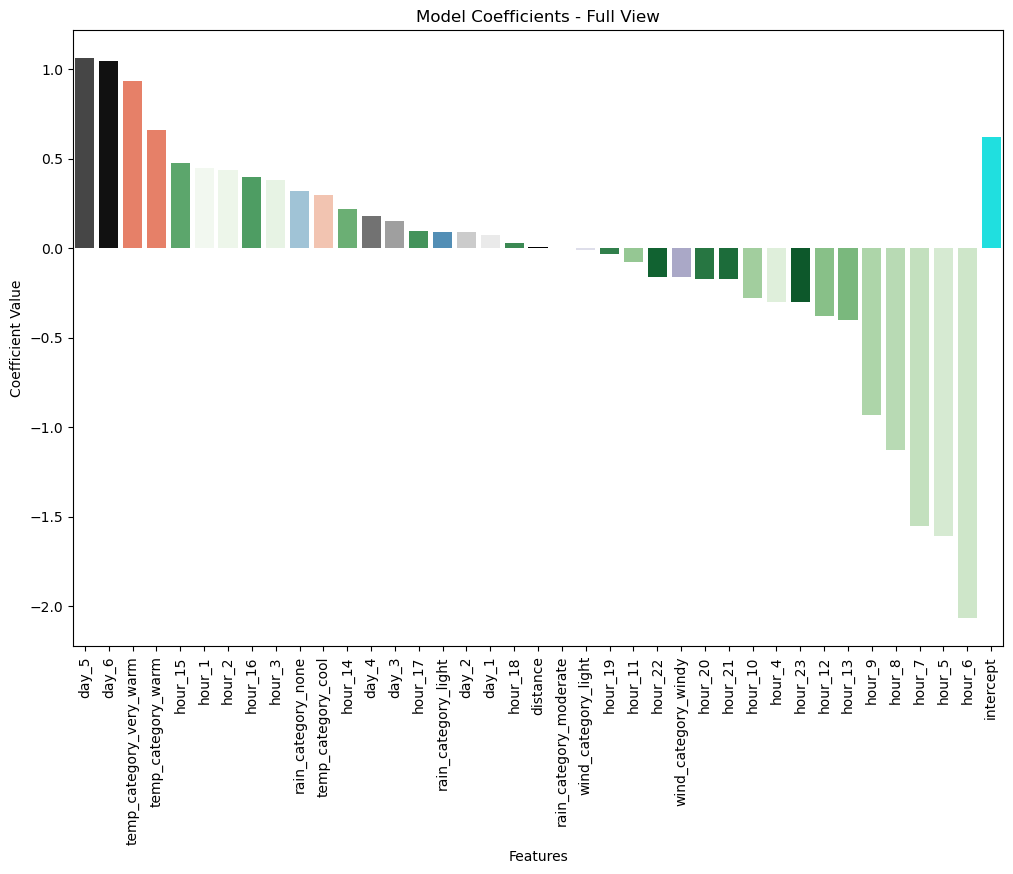

In [45]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model2_dummies['travel_time']
X = df_model2_dummies.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 1: model1_day
model2 = LinearRegression()
model2.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model2_coeffs = build_coeffs_df(model2, X)
display(df_model2_coeffs)

## Displaying the model 1's validation serie
y_pred_model2 = model2.predict(X_test)
s_model2_validation = build_validation_serie(y_test, y_pred_model2)
display(s_model2_validation)

## Plotting a bar plot of the model's coefficients with separate colors for the different types of features
plt.figure(figsize=(12, 8))
colors = []
for idx in df_model2_coeffs.index:
    # Intercept is in cyan and is an interger (in minutes)
    if idx == 'intercept':
        colors.append('cyan')
    # Distance is in black and is an integer (in min/m)
    elif idx == 'distance':
        colors.append('black')
    # The days are a gradient from grey to black and are to be converted in integers based on the last digit
    elif idx.startswith('day_'):
        colors.append(plt.cm.Greys(int(idx.split('_')[1]) * 40))
    # The hours are a gradient of green and are to be converted in integers based on the last digit
    elif idx.startswith('hour_'):
        colors.append(plt.cm.Greens(int(idx.split('_')[1]) * 10))
    # The temperature is a gradient of red and is composed of categories (strings)
    elif idx.startswith('temp_category_'):
        colors.append(plt.cm.Reds((['cold', 'cool', 'warm', 'very_warm'].index(idx.split('_')[-1])) * 60))
    # The rain is a gradient of deep blue and is composed of categories (strings)
    elif idx.startswith('rain_category_'):
        colors.append(plt.cm.Blues((['none', 'light', 'moderate', 'heavy'].index(idx.split('_')[-1])) * 60 + 100))
    # The wind is a gradient of purple and is composed of categories (strings)
    elif idx.startswith('wind_category_'):
        colors.append(plt.cm.Purples((['calm', 'light', 'windy', 'stormy'].index(idx.split('_')[-1])) * 60))
    else:
        colors.append('gray')
sns.barplot(x=df_model2_coeffs.index, y='Coefficient', data=df_model2_coeffs.reset_index(), palette=colors)
plt.title('Model Coefficients - Full View')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

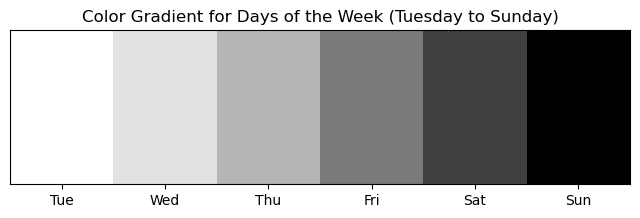

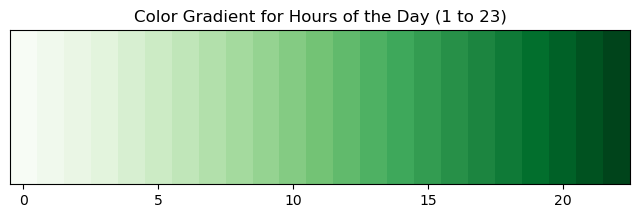

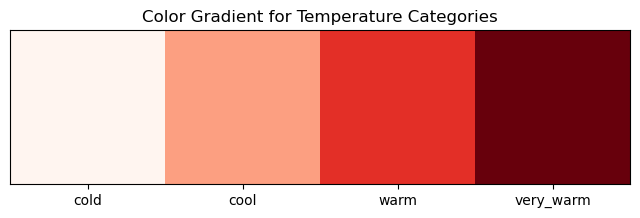

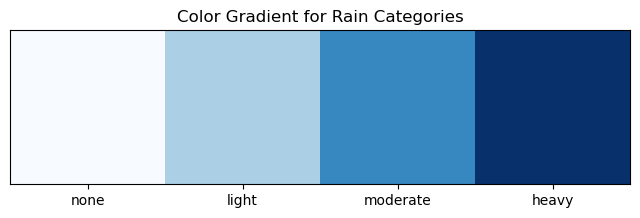

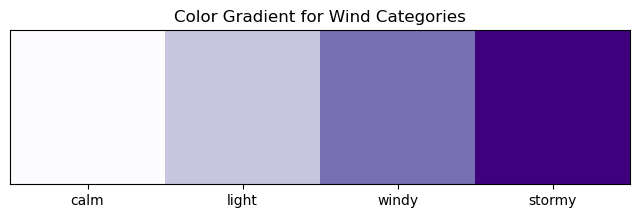

In [39]:
# Plotting the gradients legends for the previous code that plotted the complete bar graph
## Plotting a gradient to show the colors grading from Tuesday to Sunday (1 to 6)
plt.figure(figsize=(8, 2))
gradient_days = np.linspace(0, 1, 6).reshape(1, -1)
plt.imshow(gradient_days, aspect='auto', cmap='Greys')
plt.title('Color Gradient for Days of the Week (Tuesday to Sunday)')
# Changing the legend to show the days of the week
plt.xticks(ticks=np.arange(6), labels=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.show()
## Plotting a gradient to show the colors grading from Hour 1 to Hour 23
plt.figure(figsize=(8, 2))
gradient_hours = np.linspace(0, 1, 23).reshape(1, -1)
plt.imshow(gradient_hours, aspect='auto', cmap='Greens')
plt.title('Color Gradient for Hours of the Day (1 to 23)')
plt.yticks([])
plt.show()
## Plotting a gradient to show the colors grading for temperature categories
plt.figure(figsize=(8, 2))
categories_temp = ["cold", "cool", "warm", "very_warm"]
gradient_temp = np.linspace(0, 1, len(categories_temp)).reshape(1, -1)
plt.imshow(gradient_temp, aspect='auto', cmap='Reds')
plt.title('Color Gradient for Temperature Categories')
# Changing the legend to show the temperature categories
plt.xticks(ticks=np.arange(len(categories_temp)), labels=categories_temp)
plt.yticks([])
plt.show()
## Plotting a gradient to show the colors grading for rain categories
plt.figure(figsize=(8, 2))
categories_RR = ["none", "light", "moderate", "heavy"]
gradient_rain = np.linspace(0, 1, len(categories_RR)).reshape(1, -1)
plt.imshow(gradient_rain, aspect='auto', cmap='Blues')
plt.title('Color Gradient for Rain Categories')
# Changing the legend to show the rain categories
plt.xticks(ticks=np.arange(len(categories_RR)), labels=categories_RR)
plt.yticks([])
plt.show()
## Plotting a gradient to show the colors grading for wind categories
plt.figure(figsize=(8, 2))
categories_wind = ["calm", "light", "windy", "stormy"]
gradient_wind = np.linspace(0, 1, len(categories_wind)).reshape(1, -1)
plt.imshow(gradient_wind, aspect='auto', cmap='Purples')
plt.title('Color Gradient for Wind Categories')
# Changing the legend to show the wind categories
plt.xticks(ticks=np.arange(len(categories_wind)), labels=categories_wind)
plt.yticks([])
plt.show()